# Introduction

This lab has two parts. 

Part I is about inferring the presence or absence of a known set of features in an observed noisy signal.

Part II is about discovering those features, instead of assuming them a priori.

Enjoy!

In [1]:
using Gen
using Plots
include("beta_array.jl");

## Part I: Inferring the presence of features

In this part, we will work on a simple problem: Given an observed noisy signal and a set of possible features it may contain, which of these features are present in the signal? 

The demo that we will work with is based on the work of Tom Griffiths and Zoubin Ghahramani (Figure 8 in [Indian Buffet Process: An Introduction and Review](https://www.jmlr.org/papers/volume12/griffiths11a/griffiths11a.pdf)). (This lab is not about the method introduced in that paper -- we will pursue a completely different approach. But their approach is amazing -- check it out if you have time.) 

Assume that we know that an observed signal (bottom row below) is a noisy super position of a set of four features (top row below). The figure is from Figure 8 of G & G. Your task will be infer the weights of the four features given a noisy signal. 

<img src="./images/gg-blocks.png"  width="300"/>

We start with writing a Julia function to describe a data generating process of our demo. The variable `A` encodes the 4 features. `weights` are bernoulli random variables indicating whether a feature is on or off on a signal. Finally, we generate the signal `mu` by adding gaussian noise.

In [2]:
function gg_blocks_dgp()
    local A = zeros(4, 36)
    A[1, [2, 7, 8, 9, 14]] .= 1.0
    A[2, [4, 5, 6, 10, 12, 16, 17, 18]] .= 1.0
    A[3, [19, 25, 26, 31, 32, 33]] .= 1.0
    A[4, [22, 23, 24, 29, 35]] .= 1.0

    weights = zeros(1, 4)
    [weights[i] = Gen.bernoulli(0.5) for i = 1:4]
    while sum(weights) == 0
        [weights[i] = Gen.bernoulli(0.5) for i = 1:4]
    end
    
    mu = weights * A 
    
    mu = Gen.broadcasted_normal(mu, .1)

    return mu
end;

Let's call this function to generate an observation and visualize it.

In [3]:
function visualize(input)
    heatmap(reshape(input, (6, 6)), clim=(0,1))
end;

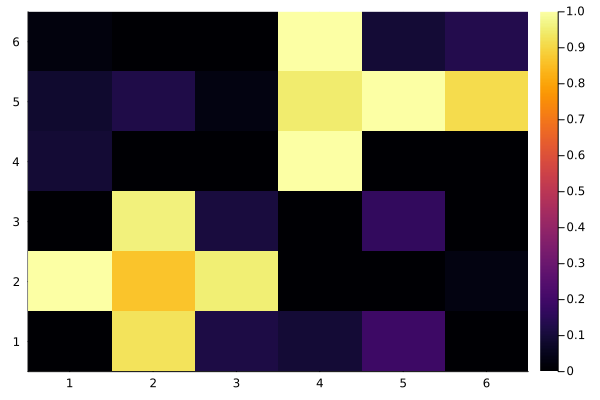

In [4]:
a = gg_blocks_dgp()
obs = Gen.choicemap()
obs[:pred] = a
visualize(obs[:pred])

Now we will write a generative model that captures the random variables we wish to model -- in this case an uninformed prior over `weights` and the likelihood function `pred`. Notice that we assume that we know the features `A`.

In [5]:
@gen function gg_blocks(A)

    weights ~ beta_array([1., 1., 1., 1.], [1., 1., 1., 1.])
    
    mu = weights' * A
    
    pred ~ Gen.broadcasted_normal(mu, .1)
    
end;

We can draw a sample from this generative model and visualize.

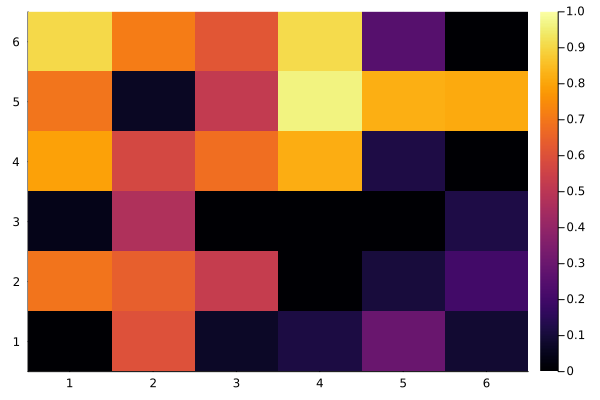

In [6]:
A = zeros(4, 36)
A[1, [2, 7, 8, 9, 14]] .= 1.0
A[2, [4, 5, 6, 10, 12, 16, 17, 18]] .= 1.0
A[3, [19, 25, 26, 31, 32, 33]] .= 1.0
A[4, [22, 23, 24, 29, 35]] .= 1.0

tr = Gen.simulate(gg_blocks, (A, ))

Gen.get_choices(tr)
b = tr[:pred]
visualize(b)

Now with that, we are ready to infer the presence of each of the four features given a noisy signal. We will do so using Gen's MAP optimization method. 

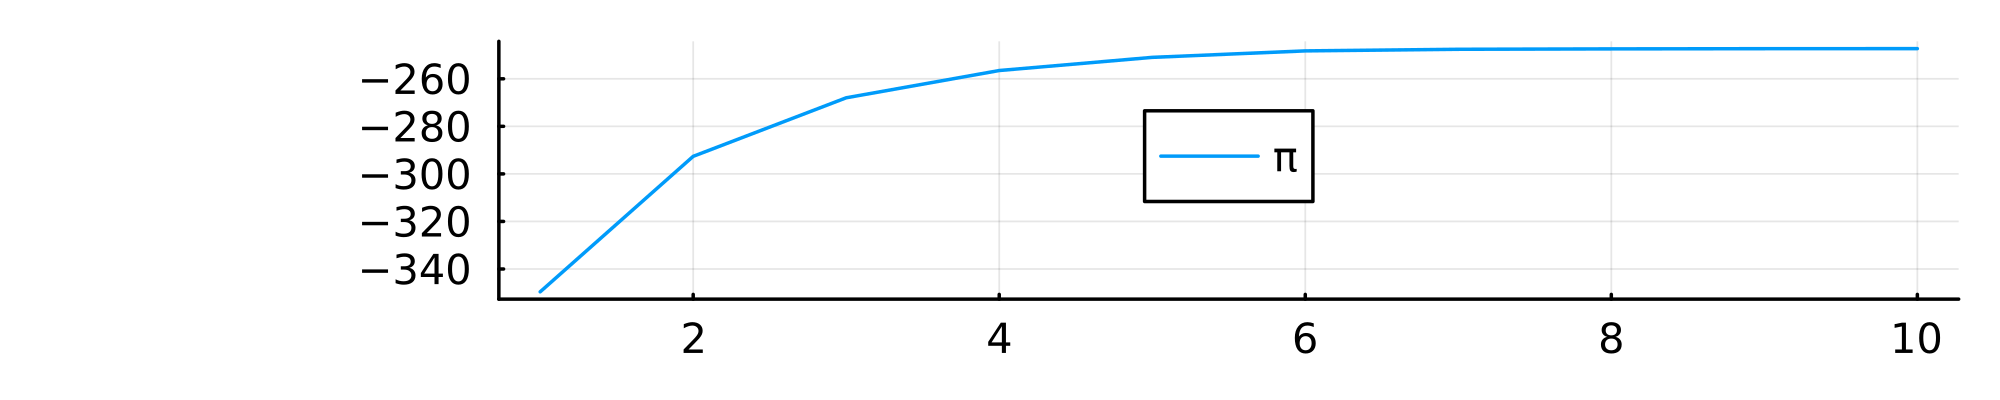

In [7]:
# initialize a random starting point
tr, _ = Gen.generate(gg_blocks, (A,), obs)
# πs is an array to collect our log proto-posterior scores
πs = []

for i=1:10
    # take a single gradient descent step with step size 1e-3 
    tr = Gen.map_optimize(tr, Gen.select(:weights), max_step_size=1e-3, min_step_size=1e-31)
    # push the log score into array
    push!(πs, Gen.get_score(tr))
end
# visualize the log score 
plot(πs, labels="π", thickness_scaling=3.5, size=(2000, 400), legend=:inside)

Notice that just 10 steps is sufficient to arrive at a solution, which is not surprising given the simplicity of the problem. Now let's look at the reconstruction of the signal by our model and print out the inferred weights.

[0.3984574617554845, 0.3694175749421202, 0.7011524060069098, 0.9999997658329345]


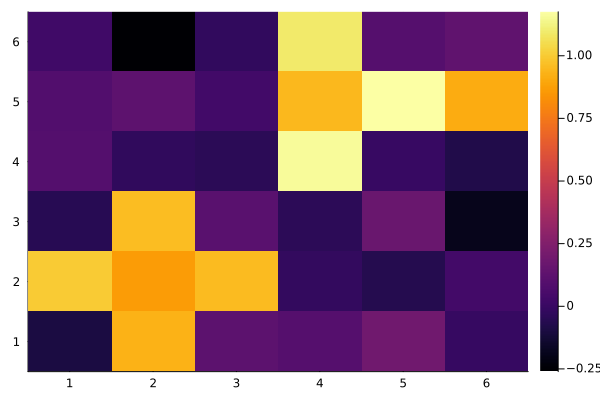

In [8]:
println(tr[:weights])
heatmap(reshape(tr[:pred], (6, 6)))

Does it look like the observed signal? Let's visualize that once again to find out.

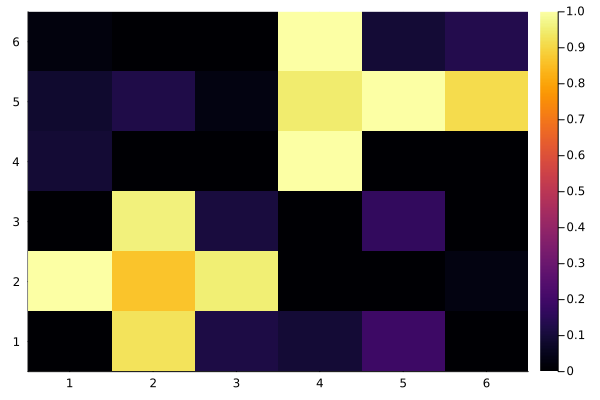

In [9]:
visualize(obs[:pred])

## Part 2: Discovering features

Now, let's not assume the features, but instead discover what they are from data. 

Unlike the G & G paper linked at the beginning, we will assume that we know the number of unique features (4 in this case).

Given a dataset of noisy signals (say, K=30 signals), we will wish to infer the individual features that are composed to create each and every signal.

We start by writing a generative model that defines the relevant random variables. This generative model has couple interesting aspects to it:

`A` is a prior over features; we assume that it's a normal distribution centered at a negative value (`-0.25`). We then activate `A` using the `tanh` function, resulting in the variable `A_activated`. The function `tanh` non-linearly maps the entirety of real number line onto (-1, 1). And crucially `tanh` is differentiable, so that we can use gradient descent for inference.

Centering `A` at a negative value (`-0.25`) reflects our assumption that the features we are hoping to discover are sparse -- in this way, most entries will be close to 0 after activating it. Moreover, activating by `tanh` ensures that our features are non-negative, 

Finally, we draw the weights `weights=>k` for each observed signal `k` and render the noisy signal itself `pred=>k`, which is `weights * A_activated`. 

In [10]:
@gen function gg_blocks_params(K)
    # the mean of A, features (parametrizing a normal distribution)
    a = repeat([-0.25], 144)
    # scale and shape of the weights (parametrizing a beta distribution)
    ab = repeat([0.5], 4)
    
    A ~ broadcasted_normal(a, 0.5)
    # tanh activation for non-negative A matrix
    A_activated = (tanh.(10 .* A) .+ 1) / 2.

    for k = 1:K
        # for each observation, draw its feature weights
        val = {:weights=>k} ~ beta_array(ab, ab)
        # some gymnastics for linear algebra (matrix multiplication: weights [1x4] * A [4x36])
        # this is needed to avoid reversediff complaints
        mu = reshape(repeat(val, outer=36) .* A_activated, (4, 36))
        mu_mu = sum(mu, dims=1)
        # likelihood
        {:pred=>k} ~ Gen.broadcasted_normal(mu_mu, .1)
    end

end;

Let's generate a dataset of noisy signals -- so that we can use it to learn our features

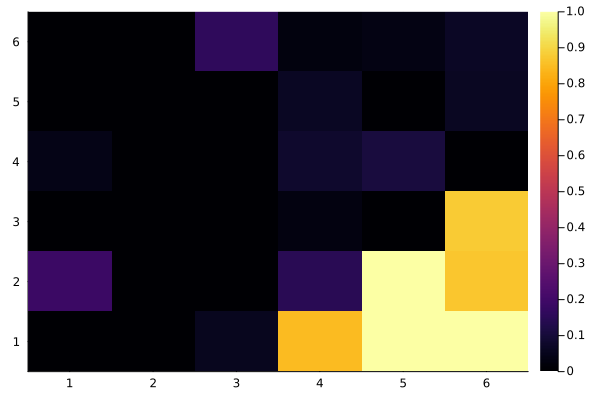

In [11]:
# synthetic data generation
constraints = Gen.choicemap()
for i=1:100
    a = gg_blocks_dgp()
    constraints[:pred => i] = a
end
visualize(constraints[:pred=>2])

The following code block implements the MAP inference over this model.

Notice that the appropriate initialization of the random variables is important. 

We initialize `A` to negative values but close to 0. This ensures that activated A is also often closer to 0, while also respecting sparsity (encouraged by our prior). Notice that we also add a bit of a random jitter on `A`; this is for symmetry breaking. Try and see what happen if you don't add that random jitter with `rand(144) * .01`.

Finally, we initialize all weights at 0.5.

In [12]:
function do_map_inference(constraints, K)
    # initialize the features A and weights weights=>k
    latents_init = Gen.choicemap()
    latents_init[:A] = repeat([-0.15], 144) .+ rand(144) * .01 # (rand(144) .- 0.5)*.75
    for k = 1:K
        latents_init[:weights=>k] = repeat([0.5], 4) #.+ rand(4) * .01
    end

    tr, _ = Gen.generate(gg_blocks_params, (K,), merge(constraints, latents_init))

    # an array to collect our log proto-posterior scores
    πs = []
    # step size in gradient descent
    lr = 1e-5
    # create a selection of weight addresses so that we can optimize 
    selection = select()
    for k = 1:K
        push!(selection, :weights => k)
    end 
    
    # optimization loop
    for i=1:500
        # update A
        tr = Gen.map_optimize(tr, select(:A), max_step_size=lr, min_step_size=1e-1)
        # updated weights
        tr = Gen.map_optimize(tr, selection, max_step_size=lr, min_step_size=1e-1)
    
        # push the log score into array
        push!(πs, Gen.get_score(tr))
    end
    return (tr, πs[end], πs)
end;

Now we will run this MAP optimization algorithm for 10 times (well 11) and pick the best performing one.

At the end, we plot how log scored improved for that best chain. 

In [13]:
K = 30
tr, score, πs = do_map_inference(constraints, K)
for i = 1:10
    new_tr, new_score, new_πs = do_map_inference(constraints, K)
    if new_score > score
        tr = new_tr
        score = new_score
        πs = new_πs
    end
end;

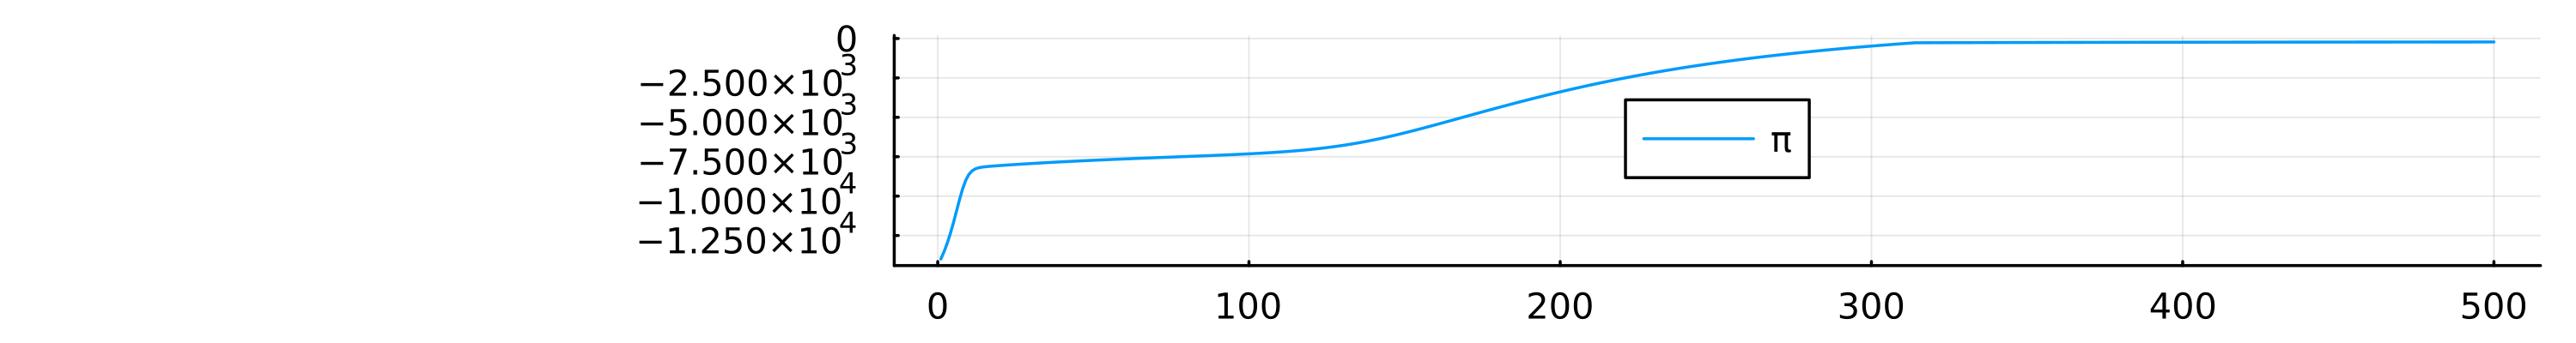

In [14]:
# visualize the log score 
plot(πs, labels="π", thickness_scaling=3.5, size=(3000, 400), legend=:inside)

Now let's extract our discovered features matrix `A`

In [15]:
A_map_orig = (tanh.(10 .* tr[:A]) .+ 1) / 2.
A_map = reshape(A_map_orig, (4, 36));

Let's start by visualizing the four features we inferred. 

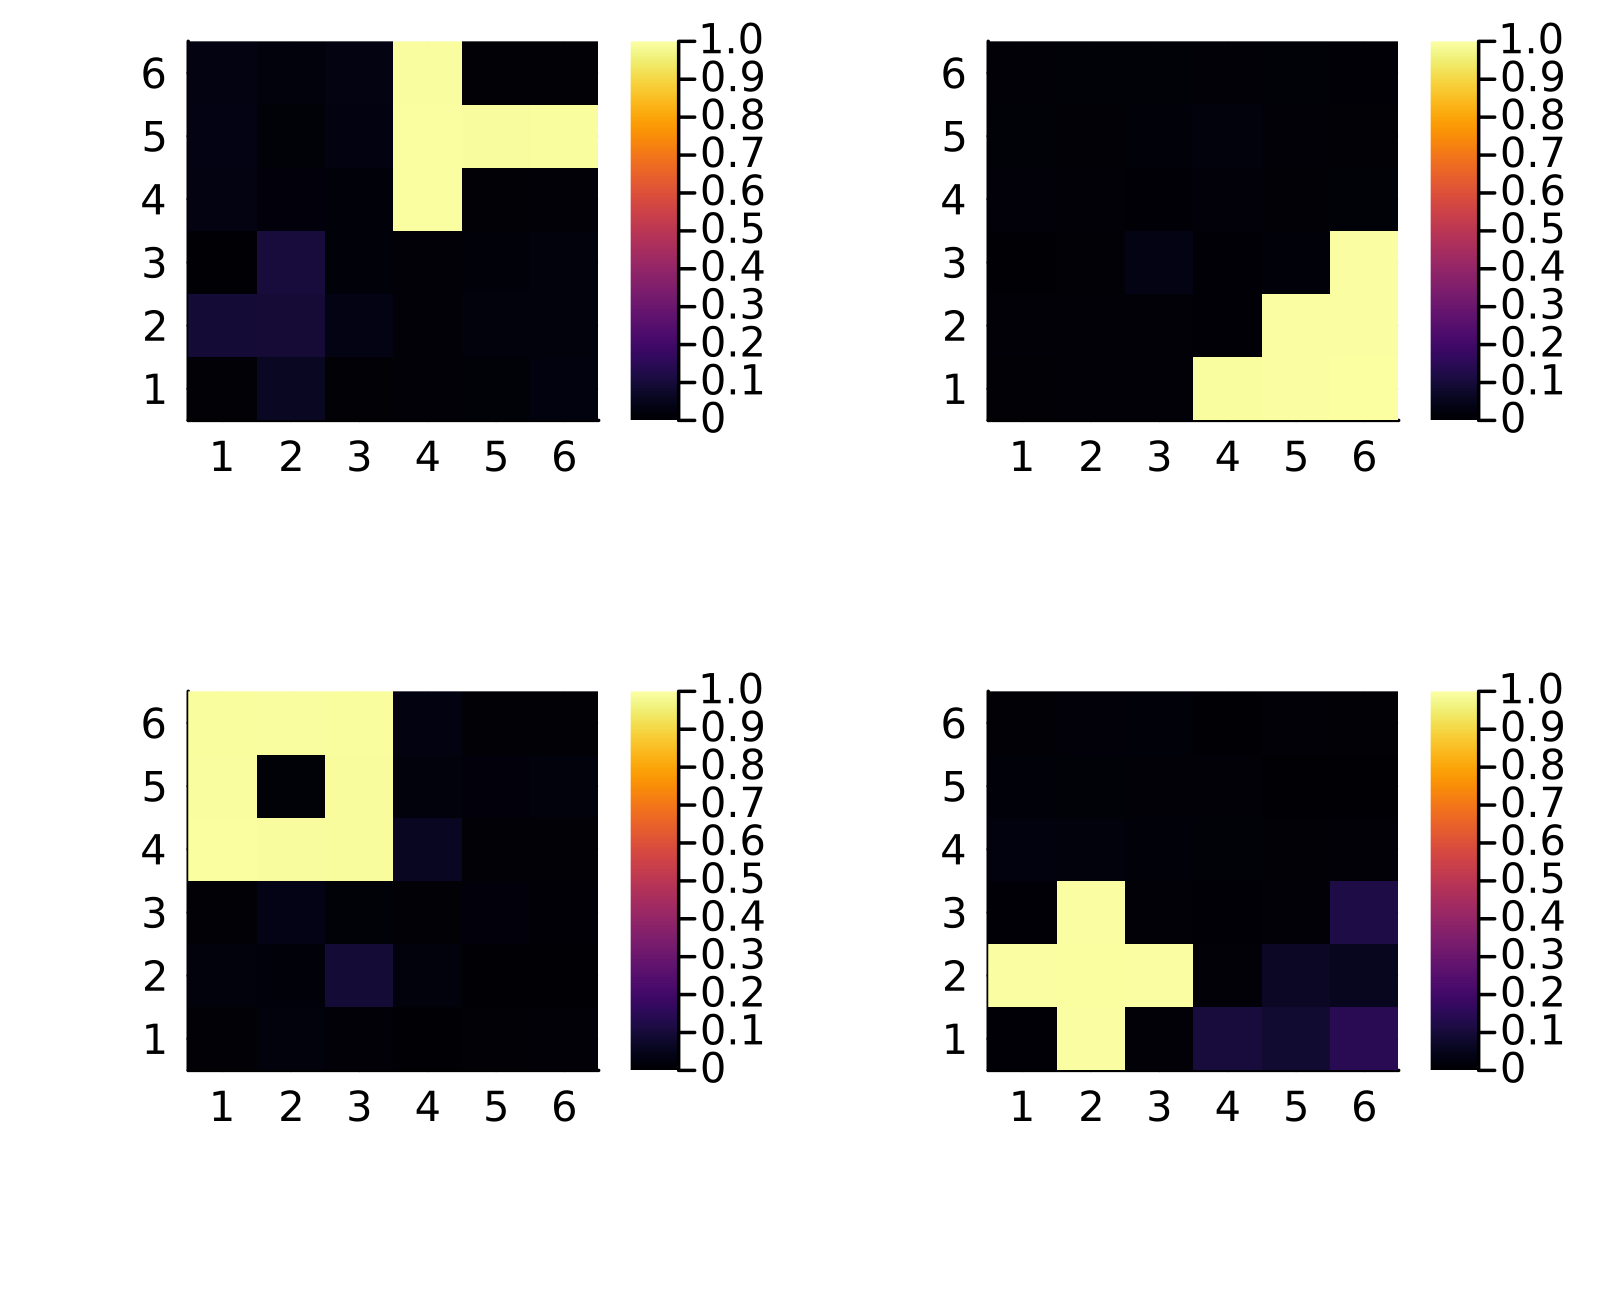

In [16]:
p1 = heatmap(reshape(A_map[1,:], (6, 6)), clim=(0,1))
p2 = heatmap(reshape(A_map[2,:], (6, 6)), clim=(0,1))
p3 = heatmap(reshape(A_map[3,:], (6, 6)), clim=(0,1))
p4 = heatmap(reshape(A_map[4,:], (6, 6)), clim=(0,1))
plot(p1, p2, p3, p4, thickness_scaling=3.5, size=(1600, 1300))

Not bad, I think. Now let's look at some of the reconstructions of the observed signals. We will take the corresponding inferred weights of an observed signal and reconstruct it using our discovered features. 

[0.825504537442739, 0.8366265295696823, 0.0987394423762221, 0.7619684434707971]


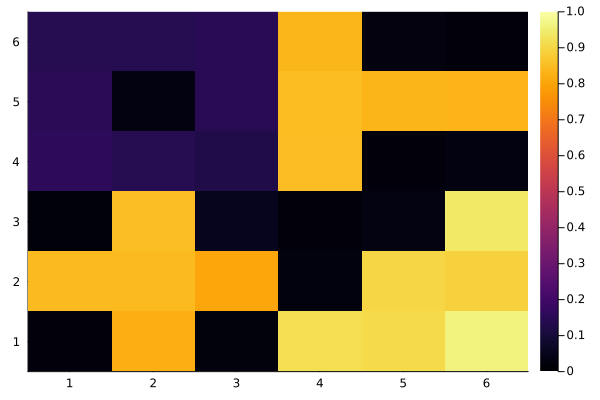

In [17]:
obs_index = 1
val = tr[:weights=>obs_index]
println(val)
m = repeat(val, outer=36) .* A_map_orig
mu = reshape(m, (4, 36))
mu_mu = sum(mu, dims=1)
visualize(mu_mu)

Is it looking like the observed signal? Let's visualize it to find out. (You can try this for a different observed signals by changing the `obs_index`.)

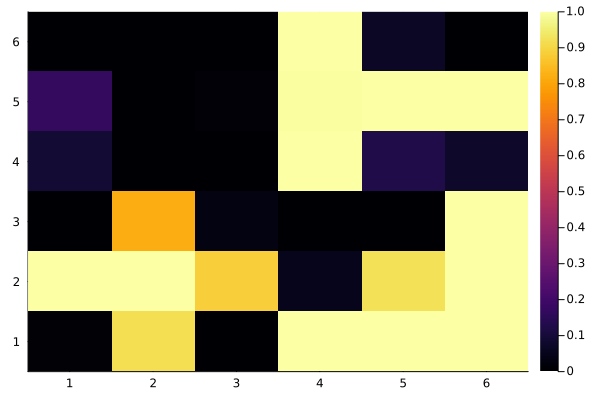

In [18]:
visualize(constraints[:pred=>obs_index])